In [ ]:
from google.colab import drive
drive.mount("/content/drive")

path_data = '/content/drive/MyDrive/Colab/'

# Projet CV : Classification de races de chiens

Le but de ce projet est de développer un programme python capable de classer les images en fonction de la race du chien présent sur une image. Pour cela, l'algorithme Deep Learning sera entraîné sur le [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/). Les étapes de découpages (*cropping*) des images sont présentées dans le notebook ci-joint. On présente ici la démarche.


Dans la première partie, les différentes étapes de traitement d'images réalisées sur les données seront présentés: Amélioration du contraste de l'image (en égalisant l'histogramme représentant la répartition de ses pixels selon leur intensité) et filtrage non-linéaire pour la réduction du bruit dans l'image (en applicant le filtre médian qui remplace la valeur de chaque pixel par la médiane). En pratique, ces opérations s'effectuent à-la-volée (*on-the-fly*) lors de la modélisation. 

Dans la deuxième partie, on présente une approche d'apprentissage non-supervisée (pré-Deep Learning) pour la classification des différentes races. L'algorithme **SIFT** de détection des *features* dans une image sera employé pour avoir une représentation vectorielle (*embedding*) de l'ensemble des images du jeu de donnée. On peut alors comparer deux images à l'aide du calcul de la similarité cosinus entre les deux vecteurs représantant ces deux images.

Dans la troisième partie, on utilise les algorithmes Deep Learning. On utilisera un réseau de neurones convolutifs simple en tant que modèle *baseline*. On utilisera les algorithmes pré-entraîné (*Transfer Learning*) `VGG16`, `Xception` et `ResNet50` en remplaçant la dernière couche *fully-connected* par un classifieur adapté à notre problème. Nous allons utiliser le *framework* `keras_tuner` pour optimiser l'architecture finale de chaque modèle. Enfin, le `learning_rate` et le `batch_size` sont optimisés via *grid search*.

# <font color="#00afe6">Sommaire</font>
0. [Chargement des données.](#section_0)                       
1. [Traitement des images.](#section_1)   
    1.1 [ Égalisation de l'histogramme.](#section_1_1)            
    1.2 [ Débruitage via application filtre non-linéaire.](#section_1_2)            
2. [Classification non-supervisée via extraction des features SIFT. ](#section_2)     
    2.1 [Extraction de features SIFT.](#section_2_1)            
    2.2 [Clustering.](#section_2_2)            
3. [Classification supervisée via algorithmes de Deep Learning.](#section_3)                           
    3.1 [Préparation des données via l'API data de tensorflow.](#section_3_1)                   
    3.2 [CNN.](#section_3_2)                   
    3.3 [Transfer Learning avec keras_tuner.](#section_3_3)                   

In [2]:
# Import libraries
import os, shutil, time
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import cv2

from scipy.cluster.vq import kmeans, vq

from sklearn.metrics import confusion_matrix
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# <font color="red" id=section_0> 0. Chargement des données. </font>

In [ ]:
sampl_path = path_data + 'DogBreedsData/Data_sample_B20_n0/'

In [ ]:
# Count the number of classes (dogs breeds)

breed_names = os.listdir(sampl_path)
print("Number of breeds in dataset:", (len(breed_names)))

Number of breeds in dataset: 20


In [ ]:
breed_names

['Shetland_sheepdog',
 'Scotch_terrier',
 'malinois',
 'Lhasa',
 'Border_collie',
 'Great_Pyrenees',
 'Irish_setter',
 'golden_retriever',
 'malamute',
 'Kerry_blue_terrier',
 'Walker_hound',
 'affenpinscher',
 'soft',
 'otterhound',
 'Lakeland_terrier',
 'Siberian_husky',
 'Sealyham_terrier',
 'bluetick',
 'EntleBucher',
 'English_setter']

In [ ]:
# Count number of pictures for each breed
df_breeds = pd.DataFrame(
    index=breed_names,
    data=[len(os.listdir(sampl_path + breed_name)) for breed_name in breed_names],
    columns=["num_pictures"]
)
df_breeds = df_breeds.sort_values(by=['num_pictures'], ascending=False)
df_breeds.T

Great_Pyrenees  EntleBucher  Sealyham_terrier  Lakeland_terrier  \
num_pictures             213          202               202               197   

              Siberian_husky  Lhasa  Kerry_blue_terrier  malamute  bluetick  \
num_pictures             192    186                 179       178       171   

              English_setter  Scotch_terrier  Shetland_sheepdog  soft  \
num_pictures             161             158                157   156   

              Irish_setter  Walker_hound  otterhound  affenpinscher  \
num_pictures           155           153         151            150   

              golden_retriever  Border_collie  malinois  
num_pictures               150            150       150

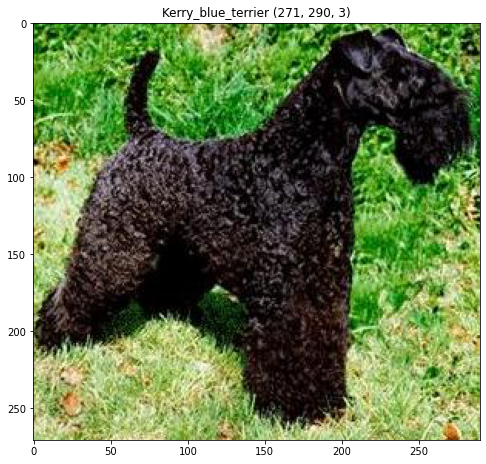

In [ ]:
# Choose random image
rand_idx = np.random.choice(range(len(breed_names)))
rand_img = plt.imread(sampl_path + breed_names[rand_idx] + '/' + 
                      np.random.choice(os.listdir(sampl_path + breed_names[rand_idx])))

# Plot
plt.figure(figsize=(8,8))
plt.title("{} {}".format(breed_names[rand_idx],rand_img.shape))
plt.imshow(rand_img) 
plt.show()

# <font color="red" id=section_1>1. Traitement des images. </font>

## <font color="red" id=section_1_1> 1.1 Égalisation de l'histogramme. </font>

In [ ]:
# # Define test image

# test_image = (crop_dir + "Great_Pyrenees/n02111500_1050.jpg")
# test_image = cv2.imread(test_image)

test_image = rand_img

In [ ]:
# Transform image with differents color sets
img_RGB = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
img_grayscale = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
img_YUV = cv2.cvtColor(test_image,cv2.COLOR_BGR2YUV)

In [ ]:
# Create histogram
def plot_histogram(init_img, convert_img):
    """Function allowing to display the initial
    and converted images according to a certain
    colorimetric format as well as the histogram
    of the latter. 

    Parameters
    -------------------------------------------
    init_img : list
        init_img[0] = Title of the init image
        init_img[1] = Init openCV image
    convert_img : list
        convert_img[0] = Title of the converted
        convert_img[1] = converted openCV image
    -------------------------------------------
    """
    hist, bins = np.histogram(
                    convert_img[1].flatten(),
                    256, [0,256])
    # Cumulative Distribution Function
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()

    # Plot histogram
    fig = plt.figure(figsize=(25,6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(init_img[1])
    plt.title("{} Image".format(init_img[0]), 
              color="#343434")
    
    plt.subplot(1, 3, 2)
    plt.imshow(convert_img[1])
    plt.title("{} Image".format(convert_img[0]), 
              color="#343434")
    
    plt.subplot(1, 3, 3)
    plt.plot(cdf_normalized, 
             color='r', alpha=.7,
             linestyle='--')
    plt.hist(convert_img[1].flatten(),256,[0,256])
    plt.xlim([0,256])
    
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.title("Histogram of converted image")
    
    plt.show()

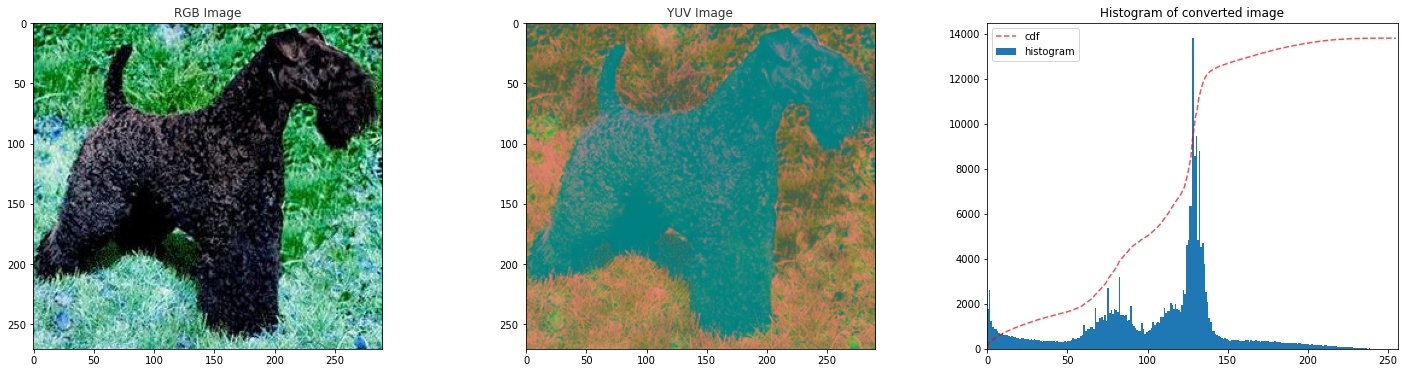

In [ ]:
# Original image
plot_histogram(["RGB", img_RGB], ["YUV", img_YUV])

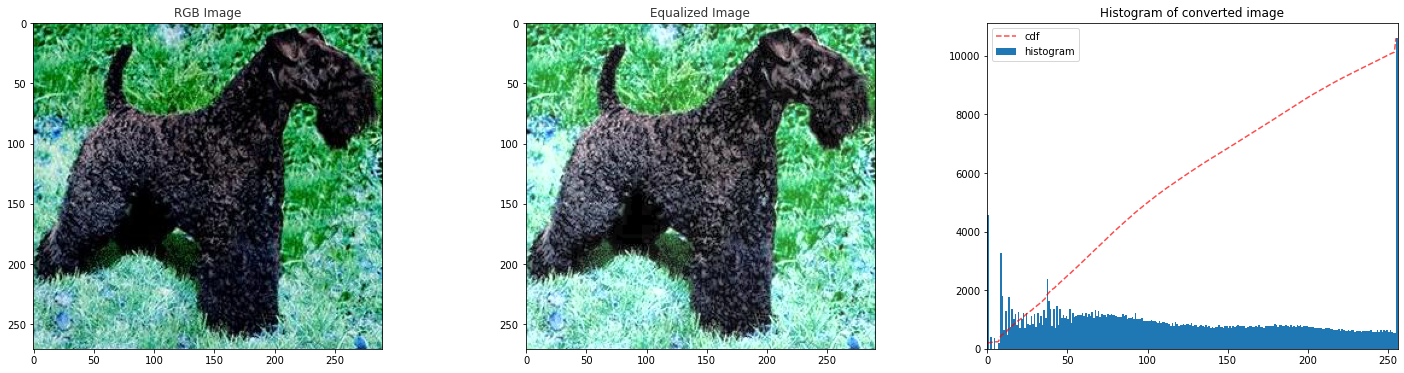

In [ ]:
# Equalization
img_YUV[:,:,0] = cv2.equalizeHist(img_YUV[:,:,0])
img_equ = cv2.cvtColor(img_YUV, cv2.COLOR_YUV2RGB)
plot_histogram(["RGB", img_RGB], ["Equalized", img_equ])

## <font color="red" id=section_1_2> 1.2 Débruitage via application filtre non-linéaire. </font>

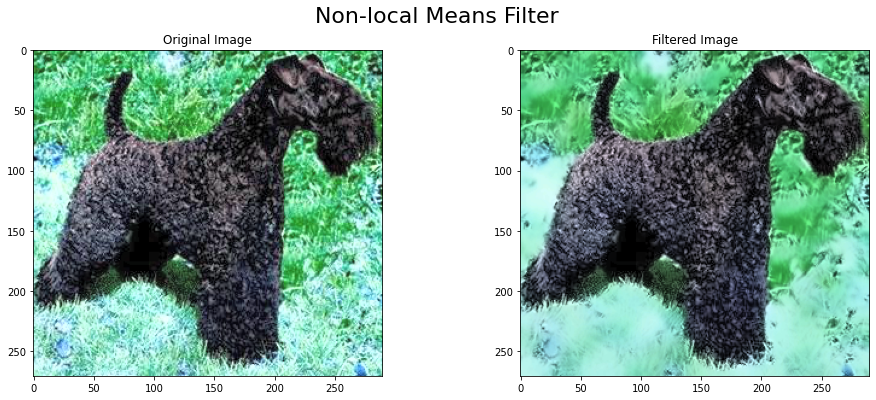

In [ ]:
# Apply
dst_img = cv2.fastNlMeansDenoisingColored(
    src=img_equ,
    dst=None,
    h=10,
    hColor=10,
    templateWindowSize=7,
    searchWindowSize=21)

# Show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_equ)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(dst_img)
plt.title("Filtered Image")
plt.suptitle("Non-local Means Filter",
             color="black", 
             fontsize=22, y=.98)
plt.show()

# <font color="red" id=section_2> 2. Classification non-supervisée via extraction des *features* SIFT. </font>

L'objectif de cette partie n'est pas de développer un algorithme pour résoudre le problème de classification qui nous intéresse mais plutôt de montrer comment on peut aborder ce problème en appliquant une technique d'extraction de features. Pour cela, nous allons travailler avec 150 images par races. 


L'algorithme **SIFT** permet d'extraire des features (ou points d'intérêt, ou encore *keypoints*) d'une image et de calculer leurs *descripteurs*. Ces derniers sont des vecteurs (de dimension 128) qui décrivent le voisinage des features auxquels ils sont associés. À l'aide de la méthode `SIFT_create()` de la librairie `opencv`, on obtient les features et descripteurs détectés sur chaque image (préalablement pré-traitée). Ensuite, on crée un "dictionnaire" via clustering des descripteurs construit précédemment. Les centroïdes des clusters trouvés sont appelés les *visual words*. On décrit alors une image en fonction de l'histogramme représentant les fréquences des différents *visual words* qu'elle contient. On a alors un embedding *bag-of-features* (ou encore *bag-of-visual-words*): chaque image est représentée par un tableau numpy - de dimension égale au nombre de clusters - dans lequel on a stocké (et normalisé) l'histogramme. À ce stade, on peut alors appliquer les algorithmes de classification supervisés classiques Machine Learning pour apprendre à assigner chaque représentation bag-of-features à une classe. Ici, nous allons plutôt utiliser un simple calcul de similarité. Pour plus de détails sur la théorie et l'implémentation voir [cet article](https://www.pinecone.io/learn/bag-of-visual-words/).


In [ ]:
print(breed_names)

['Shetland_sheepdog', 'Scotch_terrier', 'malinois', 'Lhasa', 'Border_collie', 'Great_Pyrenees', 'Irish_setter', 'golden_retriever', 'malamute', 'Kerry_blue_terrier', 'Walker_hound', 'affenpinscher', 'soft', 'otterhound', 'Lakeland_terrier', 'Siberian_husky', 'Sealyham_terrier', 'bluetick', 'EntleBucher', 'English_setter']


In [ ]:
nb_file_per_breed = 150

### Load and reshape images

In [ ]:
def construct_imageTuple(IMAGE_SIZE, breed_names=breed_names, sampl_path=sampl_path):
    # List of tuples for all images
    imgTuple_list = []

    start_time = time.time()

    for breed in breed_names:
        print(f"breedName {breed} length is {len(os.listdir(sampl_path + breed))}")
        # Random sample of "nb_file_per_breed" images
        train_filenames = random.sample(
            os.listdir(sampl_path + breed), 
            nb_file_per_breed
        )
        for filename in train_filenames:
            file_path = sampl_path + breed + '/' + filename
            # Load
            image = cv2.imread(file_path)
            # Reshape
            image = cv2.resize(
                image, 
                (IMAGE_SIZE, IMAGE_SIZE), 
                interpolation = cv2.INTER_AREA)
            imgTuple_list.append((image, breed))
        del image
        
    end_time = time.time()
    total_time = end_time - start_time
    print()
    print(f'Total time = {total_time} s')

    return imgTuple_list

In [ ]:
IMAGE_SIZE = 128
CHANNELS = 3

orig_img_list = construct_imageTuple(IMAGE_SIZE=IMAGE_SIZE)

breedName Shetland_sheepdog length is 157
breedName Scotch_terrier length is 158
breedName malinois length is 150
breedName Lhasa length is 186
breedName Border_collie length is 150
breedName Great_Pyrenees length is 213
breedName Irish_setter length is 155
breedName golden_retriever length is 150
breedName malamute length is 178
breedName Kerry_blue_terrier length is 179
breedName Walker_hound length is 153
breedName affenpinscher length is 150
breedName soft length is 156
breedName otterhound length is 151
breedName Lakeland_terrier length is 197
breedName Siberian_husky length is 192
breedName Sealyham_terrier length is 202
breedName bluetick length is 171
breedName EntleBucher length is 202
breedName English_setter length is 161

Total time = 46.15207028388977 s


In [ ]:
Nb_images = len(orig_img_list)
Nb_images

3000

In [ ]:
# example of an imageTuple
pos_img = random.randint(0,Nb_images)
orig_img_list[pos_img][0].shape, orig_img_list[pos_img][1]

((128, 128, 3), 'Great_Pyrenees')

In [ ]:
def sub_plots(imageTuple):
    Nb_sub_images = 6
    rand_img_list_spl = random.sample(list(np.arange(Nb_images)),Nb_sub_images)
    num_cols = 3
    num_rows = np.rint(Nb_sub_images/num_cols) +1  
    fig = plt.figure(figsize=(10,10))
    for i in range(Nb_sub_images):
        plt.subplot(num_rows,num_cols,i+1)
        pos = rand_img_list_spl[i]
        show_img(imageTuple[pos])
    fig.tight_layout()
    plt.show()     
    
def show_img(imageTuple):
    plt.imshow(imageTuple[0])
    plt.title(imageTuple[1])

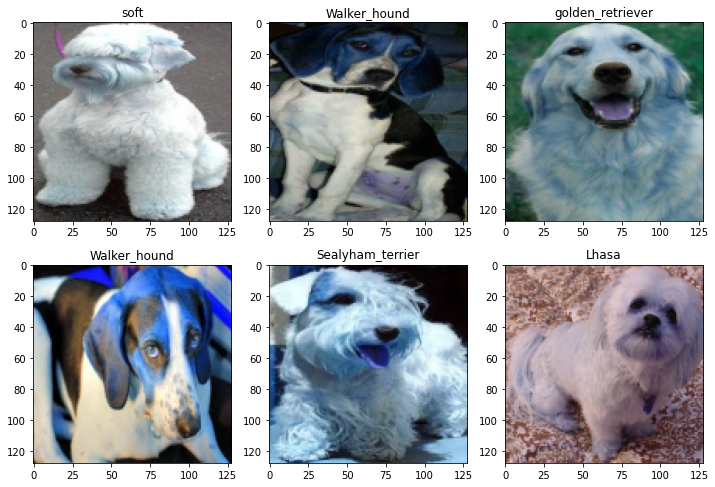

In [ ]:
# Original images
sub_plots(orig_img_list)

### Preprocessing

In [ ]:
# Equalize
def equalize_images(imageTuple):
    img = imageTuple[0]
    img_YUV = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
    # Equalization
    img_YUV[:,:,0] = cv2.equalizeHist(img_YUV[:,:,0])
    img_equ = cv2.cvtColor(img_YUV, cv2.COLOR_YUV2RGB)
    # Apply non-local means filter on test img
    dst_img = cv2.fastNlMeansDenoisingColored(
        src=img_equ,
        dst=None,
        h=10,
        hColor=10,
        templateWindowSize=7,
        searchWindowSize=21
    )
    return (dst_img, imageTuple[1])

# Calcul
equ_img_list = []
for i in tqdm.tqdm(range(Nb_images), total=Nb_images):
    equ_img_list.append(equalize_images(orig_img_list[i]))

100%|██████████| 3000/3000 [03:26<00:00, 14.52it/s]


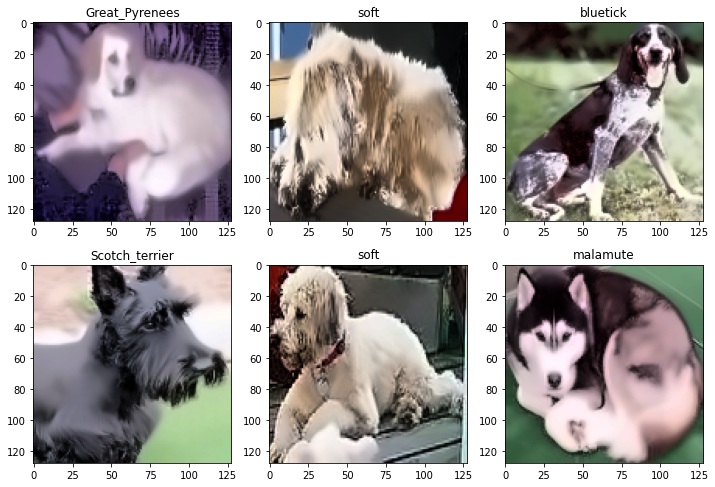

In [ ]:
# Equalized images
sub_plots(equ_img_list)

In [ ]:
def whitening_images(all_imageTuples, IMAGE_SIZE=IMAGE_SIZE):
    
    size = len(all_imageTuples)
    images = np.zeros((size,IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    for i in range(size):
        images[i,:] = all_imageTuples[i][0]

    img = images.reshape(images.shape[0], images.shape[1]*images.shape[2]*images.shape[3])
    img_norm   = img / images.shape[1]
    img_norm_n = img_norm - img_norm.mean(axis=0)
    
    print('Start SVD...')
    cov_img    = np.cov(img_norm_n, rowvar=False)
    print(f'cov mat of shape ({IMAGE_SIZE}x{IMAGE_SIZE}x{CHANNELS}) == {cov_img.shape}')
    start_time = time.time()
    U,S,_      = np.linalg.svd(cov_img)    
    end_time   = time.time()
    total_time = (end_time - start_time)/60
    print(f'... end SVD. Total time = {total_time} min.')
    epsilon = 0.1
    print('Start ZCA...')
    start_time = time.time()
    img_ZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(img_norm_n.T).T
    end_time   = time.time()
    total_time = (end_time - start_time)/60
    print(f'... end ZCA. Total time = {total_time} min.')
    
    img_ZCA_rescaled = (img_ZCA - img_ZCA.min()) / (img_ZCA.max() - img_ZCA.min())
    out_img = img_ZCA_rescaled.reshape(images.shape[0], images.shape[1], images.shape[2], images.shape[3])
    
    all_out_img = []
    out_img_uint = np.zeros(out_img.shape)
    for i in tqdm.tqdm(range(size), total=size):
        out_img_uint[i,:] = out_img[i,:]*255
        all_out_img.append((out_img_uint[i,:].astype("uint8"), all_imageTuples[i][1]))
    
    return all_out_img

# En local, utiliser "image-size = (16,16)" au maximum !
print('Reconstruct imageTuple with image-size = (64,64) \n')
test_img_list = construct_imageTuple(IMAGE_SIZE=64)
print('-------\n')
whi_img_list  = whitening_images(test_img_list, IMAGE_SIZE=64)

Reconstruct imageTuple with image-size = (64,64) 

breedName Shetland_sheepdog length is 157
breedName Scotch_terrier length is 158
breedName malinois length is 150
breedName Lhasa length is 186
breedName Border_collie length is 150
breedName Great_Pyrenees length is 213
breedName Irish_setter length is 155
breedName golden_retriever length is 150
breedName malamute length is 178
breedName Kerry_blue_terrier length is 179
breedName Walker_hound length is 153
breedName affenpinscher length is 150
breedName soft length is 156
breedName otterhound length is 151
breedName Lakeland_terrier length is 197
breedName Siberian_husky length is 192
breedName Sealyham_terrier length is 202
breedName bluetick length is 171
breedName EntleBucher length is 202
breedName English_setter length is 161

Total time = 18.601282119750977 s
-------

Start SVD...
cov mat of shape (64x64x3) == (12288, 12288)
... end SVD. Total time = 27.152605112393697 min.
Start ZCA...
... end ZCA. Total time = 4.3805969953536

100%|██████████| 3000/3000 [00:00<00:00, 3352.28it/s]


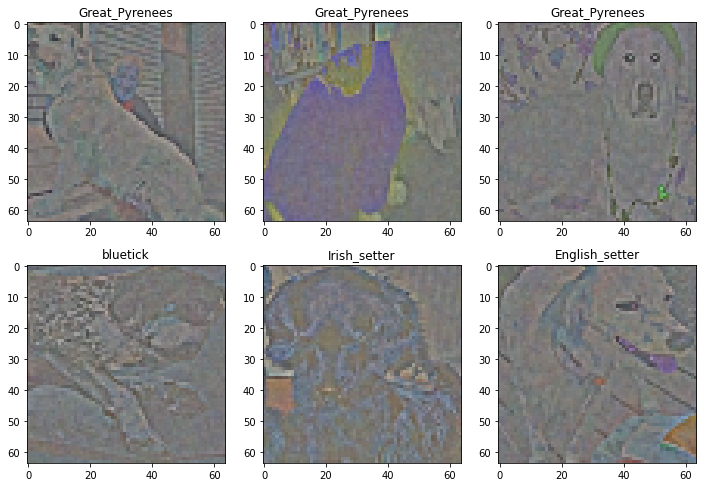

In [ ]:
# Whitened images
sub_plots(whi_img_list)

## <font color="red" id=section_2_1> 2.1. Extraction de features SIFT. </font>

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()

def apply_sift(imageTuple):
    # extract keypoints and descriptors for each image
    kps, des = sift.detectAndCompute(imageTuple[0], None)
    return kps, des if des is not None else np.array([]).reshape(0, 128)

def key_des_extract(imageTuple):
    size        = len(imageTuple)
    #
    print('Constructing keypoints & descriptors...')
    keypoints   = []
    descriptors = []
    for i in tqdm.tqdm(range(size), total=size):
        img_keypoints, img_descriptors = apply_sift(imageTuple[i])
        keypoints.append(img_keypoints)
        descriptors.append(img_descriptors)
    #
    print()
    #
    print('Drawing Keypoints for visualization...')
    output_images = []
    for i in tqdm.tqdm(range(size), total=size):
        image_key = cv2.drawKeypoints(
            imageTuple[i][0], 
            keypoints[i], 
            0, 
            (255, 0, 0),
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
            )
        output_images.append((image_key,imageTuple[i][1]))    
    #
    return output_images, keypoints, descriptors

Constructing keypoints & descriptors...


100%|██████████| 3000/3000 [00:05<00:00, 515.33it/s]



Drawing Keypoints for visualization...


100%|██████████| 3000/3000 [00:00<00:00, 52636.05it/s]


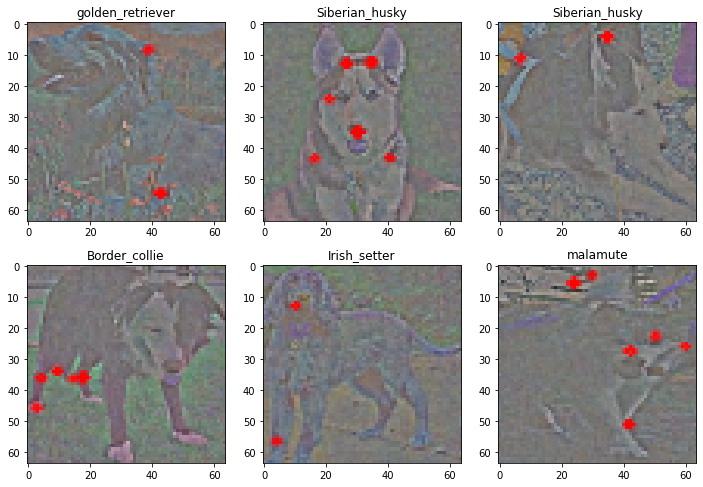

In [ ]:
# # Apply on original images
# output_image, keypoints, descriptors = key_des_extract(rand_img_list)

# Apply on whitened images
output_image, keypoints, descriptors = key_des_extract(whi_img_list)

print()
# images and descriptors
sub_plots(output_image)

In [ ]:
# Apply on equalized images
output_image, keypoints, descriptors = key_des_extract(equ_img_list) 

Constructing keypoints & descriptors...


100%|██████████| 3000/3000 [00:46<00:00, 64.36it/s]



Drawing Keypoints for visualization...


100%|██████████| 3000/3000 [00:00<00:00, 3586.27it/s]


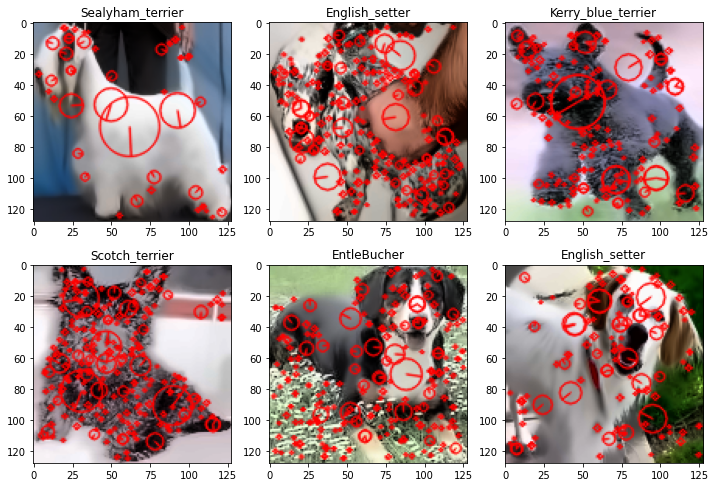

In [ ]:
# images and descriptors
sub_plots(output_image)

On peut voir d'après les deux figures ci-dessus que les *features* sont nettement mieux détectées si l'on n'applique pas l'opération de *whitening* sur les images (ici, faut aussi tenir compte de la différence de résolutions numériques). Le centre et le diamètre de chaque cercle correspondent respectivement à la position d'un *keypoint* et à la taille de la *feature*. 

On récupère également les descripteurs (vecteurs de dimension 128) associés aux *features* détectées sur chacune des images.

Il y a 141 descripteurs/features dans l'image ci-dessous.



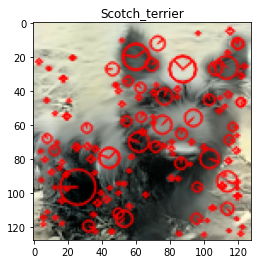

In [ ]:
pos_img = random.randint(0,Nb_images)

print(f"Il y a {descriptors[pos_img].shape[0]} descripteurs/features dans l'image ci-dessous.")
print()
show_img(output_image[pos_img])

In [ ]:
# Number of descriptors in each image
nb_des = []

for descriptor in descriptors:
    nb_des.append(descriptor.shape[0])

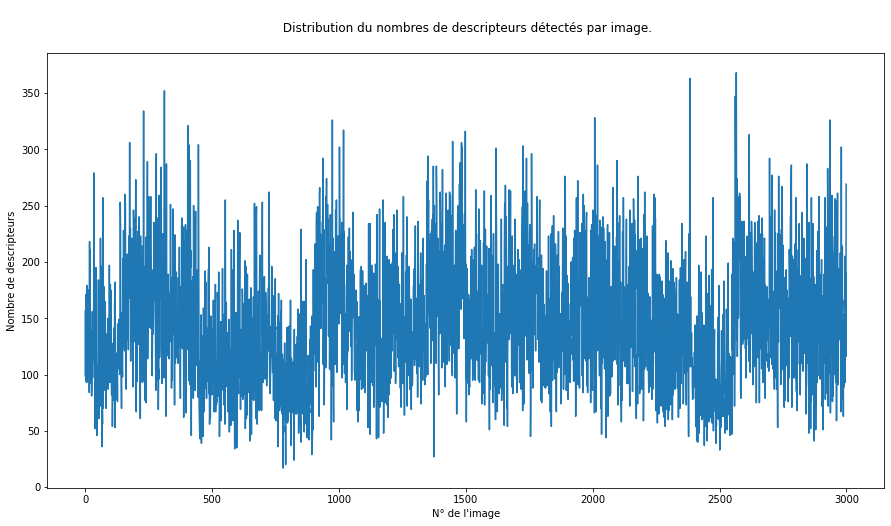

In [ ]:
# Plot
plt.figure(figsize=(15,8))
plt.plot(nb_des)
plt.title('\n Distribution du nombres de descripteurs détectés par image.\n')
plt.xlabel("N° de l'image")
plt.ylabel("Nombre de descripteurs")
plt.show()

## <font color="red" id=section_2_2> 2.2 Clustering. </font>

In [ ]:
# Collecting all descriptors
all_des = []
for descriptor in descriptors:
    all_des.append(descriptor)
    
# Stacking
all_des = np.vstack(all_des)

In [ ]:
print(f"Il y a un total de {all_des.shape[0]} descripteurs dans le 'corpus'.")

Il y a un total de 436022 descripteurs dans le 'corpus'.


Le "dictionnaire" de *visual words* va être construit à partir d'un clustering *k-means* éffectué sur l'ensemble des descripteurs du *corpus*. Le nombre *k* de clusters représente ainsi le nombre de regroupement ayant des *visual features* similaires. En pratique, on construit pour chaque image un "vecteur fréquence" (de dimension *k*) qui va représenter la fréquence d'apparition des *visual words* (donc des centroïdes issus du clustering). À l'aide de la méthode `vq` de la librairie `scipy`, il possible de connaître l'index du centroïde le plus proche pour chacun des descripteurs. 

In [ ]:
# k-means clustering to build the dictionnary
k = 150 # i.e nombre de visual words
iters = 1
print('Constructing dictionnary from all stacked descriptors...')
dictionnary, _ = kmeans(all_des, k, iters)
print('Done. \n')
print()
# 

print('Constructing visual words for all images...')
visual_words = []
for img_descriptors in tqdm.tqdm(descriptors, total=len(descriptors)):
    # for each image, map each descriptor to the nearest dictionnary entry
    img_visual_words, _ = vq(img_descriptors, dictionnary) 
    visual_words.append(img_visual_words)
print('Done. \n')
print()    
#
print('Constructing frequency vectors for all images...')
frequency_vectors = []
for img_visual_words in tqdm.tqdm(visual_words, total=len(visual_words)):
    img_frequency_vector = np.zeros(k)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
print('Done. \n')
#
# stack together in numpy array
frequency_vectors = np.stack(frequency_vectors)

Constructing dictionnary from all stacked descriptors...
Done. 


Constructing visual words for all images...


100%|██████████| 3000/3000 [00:01<00:00, 1931.48it/s]


Done. 


Constructing frequency vectors for all images...


100%|██████████| 3000/3000 [00:00<00:00, 7329.88it/s]

Done. 



In [ ]:
# dictionnaire de k=150 centroïdes de dimension (128,)
len(dictionnary), dictionnary[0].shape

(150, (128,))

In [ ]:
# Chaque image n'a pas le même nombre de visual words
len(visual_words), visual_words[0].shape

(3000, (99,))

Chaque image est maintenant représentée par un vecteur indexant la fréquence d'apparition des centroïdes (ou visual words) qu'elle contient. Ce vecteur est donc de dimension k=150.

In [ ]:
len(frequency_vectors),len(frequency_vectors[0])

(3000, 150)

Chaque image peut alors être définie par son histogramme de *visual words*.

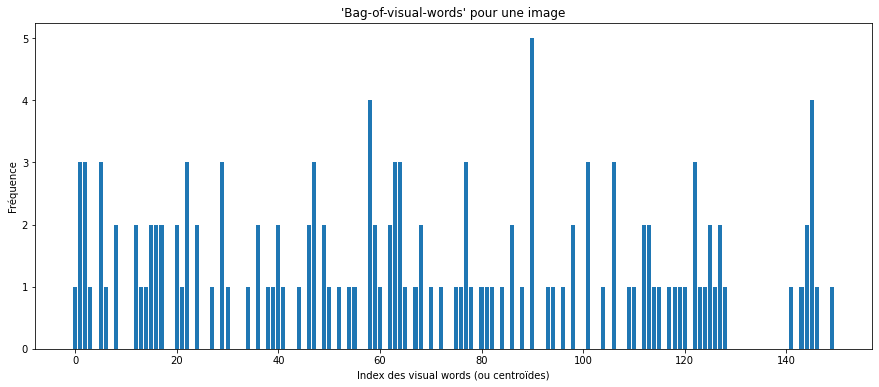

In [ ]:
# Plot histograms
plt.figure(figsize=(15,6))
plt.bar(list(range(k)), frequency_vectors[pos_img])
plt.xlabel('Index des visual words (ou centroïdes)')
plt.ylabel('Fréquence')
plt.title("'Bag-of-visual-words' pour une image")
plt.show()

### Normalisation tf-idf 

Pour finir, on transforme l'ensemble des vecteurs fréquences en features *TF-IDF*. Ainsi, les *visual words* les plus fréquents tels que l'arrière plan ont moins d'importance que ceux moins fréquents (la forme des oreilles par exemple), donc une discrimination pertinente pour une meilleure classification.

In [ ]:
# df is the number of images that a visual word appears in
# we calculate it by counting non-zero values as 1 and summing

df    = np.sum(frequency_vectors > 0, axis=0)
idf   = np.log(Nb_images/ df)
tfidf = frequency_vectors * idf

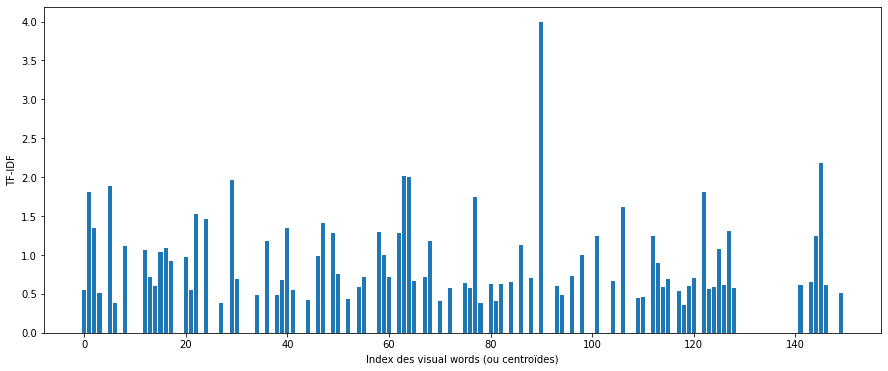

In [ ]:
# Plot histograms for an image
plt.figure(figsize=(15,6))
plt.bar(list(range(k)), tfidf[pos_img])
plt.xlabel('Index des visual words (ou centroïdes)')
plt.ylabel('TF-IDF')
plt.show()

In [ ]:
tfidf.shape

(3000, 150)

### Calcul de similarité.

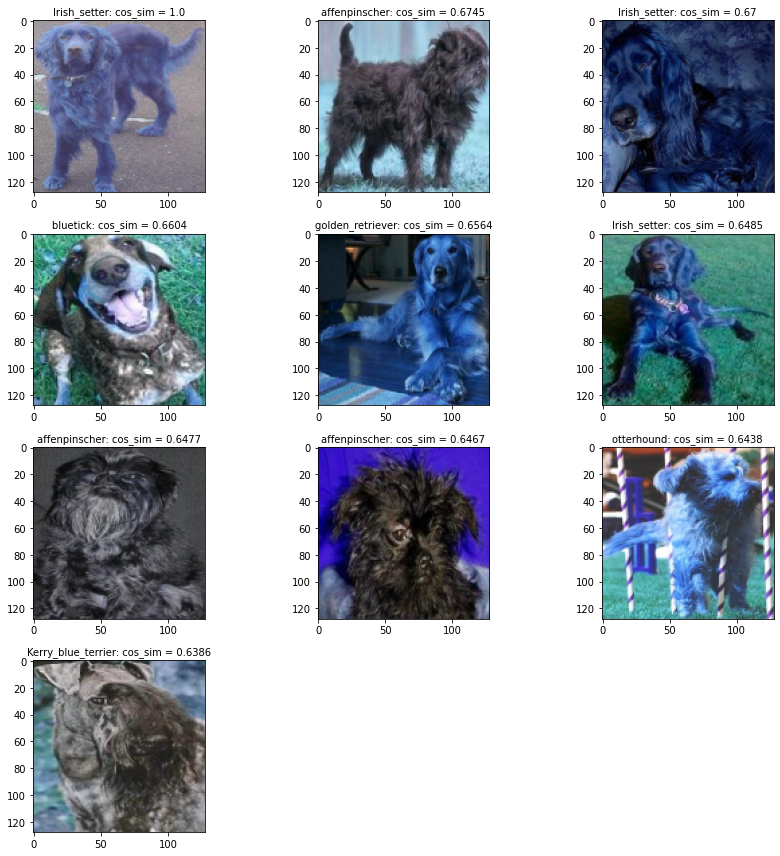

In [ ]:
# On choisit une position (i.e une image) aléatoirement
search_i = random.randint(0,Nb_images-1) # pos_img # 
# input vector parmi le dictionnaire normalisé
input_img = tfidf[search_i]

# cosine similarity with the full sample
from numpy.linalg import norm
cosine_similarity = np.dot(input_img, tfidf.T)/(norm(input_img) * norm(tfidf, axis=1))

# sort top k
top_k = 10
top_idx = np.argsort(-cosine_similarity)[:top_k]

# Plot
fig = plt.figure(figsize=(12,12))
num_cols = 3
num_rows = np.rint(top_k/num_cols) +1
for i,x in enumerate(top_idx):
    plt.subplot(num_rows,num_cols,i+1)
    plt.imshow(orig_img_list[x][0])
    plt.title(f"{orig_img_list[x][1]}: cos_sim = {round(cosine_similarity[x], 4)}", fontsize=10)
fig.tight_layout()
plt.show()

Sur la figure ci-dessus, l'image input est située en haut à gauche. La similarité avec elle-même vaut naturellement 1. Les autres images correspondent à celles avec les meilleurs scores de similarités. En raison de la diversité des prises de vue, d'arrières plans, etc ... parmi les images, le résultat de la classification selon la race n'est pas spécialement pertinent. Cependant, concernant les *bag of visual words*, on peut voir que les mêmes motifs sont généralement identifés sur les images avec des scores de similarité élevés. Par exemple, si l'image montre un chien en position debout de profil, il en est généralement de même pour les images avec les plus grand score de similarité. Idem, si l'image montre un zoom sur la tête... D'autre part, lorsque l'arrière plan ou le décor sont plus important les résultats deviennent moins pertinents.

# <font color="red" id=section_3> 3. Classification supervisée via algorithmes de Deep Learning. </font>

Dans cette partie, nous allons utiliser les algorithmes de Deep Learning pour résoudre le problème de classification. Dans un premier temps, un modèle *baseline* sera construit à partir des simples blocs de réseaux convolutionnelles (+ pooling + activation ReLu). Ensuite, on utilise trois modèles de *Transfer Learning* (en mode *fine-tuning*) que l'on va optimiser à l'aide de l'API `keras_tuner` pour de meilleures performances.

En traitement d'images, la convolution permet d'extraire (et donc apprendre) des features locales d'une image. Les couches convolutionnelles se représentent une image comme une "carte des caractéristiques" (ou *feature map*). En sortie, elles retournent une nouvelle *feature map* qui représente la présence de motifs spécifiques (ou filtres) détectés sur l'entrée. Les modèles de l'état de l'art sont tous basés sur ce type d'architecture.

## <font color="red" id=section_3_1> 3.1 Préparation des données via l'API `data` de tensorflow. </font>

In [ ]:
!pip install -U keras_tuner

In [6]:
import tensorflow as tf
import tensorflow.keras as keras

import keras_tuner
from keras_tuner.engine.hyperparameters import HyperParameters

import os
from collections import Counter

In [8]:
# Sur colab
sampl_path = path_data + 'DogBreedsData/Data_sample_B20_n0/'

# # En local
# sampl_path = 'Data_sample_B20_n0/'

In [10]:
BATCH_PLOT = 8
BATCH_SIZE = 16
IMAGE_SIZE = 128 # 256
CHANNELS=3

In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    sampl_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3411 files belonging to 20 classes.


In [12]:
class_names = dataset.class_names
class_names

['Border_collie',
 'English_setter',
 'EntleBucher',
 'Great_Pyrenees',
 'Irish_setter',
 'Kerry_blue_terrier',
 'Lakeland_terrier',
 'Lhasa',
 'Scotch_terrier',
 'Sealyham_terrier',
 'Shetland_sheepdog',
 'Siberian_husky',
 'Walker_hound',
 'affenpinscher',
 'bluetick',
 'golden_retriever',
 'malamute',
 'malinois',
 'otterhound',
 'soft']

In [13]:
n_classes    = len(class_names)
images_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
input_shape  = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [14]:
def show_classes_in_batch(ds):
    image_batch, labels_batch = next(iter(ds))

    batch_labels = Counter(list(labels_batch.numpy()))
    batch_labels = sorted(batch_labels.items(), key=lambda pair: pair[0], reverse=False)
    # batch_labels

    items = []
    frequencies = []
    for i in range(len(batch_labels)):
        items.append(batch_labels[i][0])
        frequencies.append(batch_labels[i][1])

    batch_classes = [class_names[item] for item in items]

    plt.figure(figsize=(15,6))
    indices = np.arange(len(batch_labels))
    plt.bar(indices, frequencies, color='r')
    plt.xticks(indices, batch_classes, rotation=80)
    plt.tight_layout()
    plt.title(f"Total of {len(batch_classes)} classes in batch over {len(class_names)}\n")
    plt.show()
    
def show_images_in_batch(ds, astype, BATCH_PLOT=BATCH_PLOT, num_rows=3, num_cols=4):
    plt.figure(figsize=(15, 15))
    for image_batch, labels_batch in ds:
        for i in range(BATCH_PLOT):
            ax = plt.subplot(num_rows, num_cols, i + 1)
            if astype:
                plt.imshow(image_batch[i].numpy().astype("uint8"))
            else:
                plt.imshow(image_batch[i].numpy()) #.astype("uint8"))
            plt.title(class_names[labels_batch[i]])
            plt.axis("off")

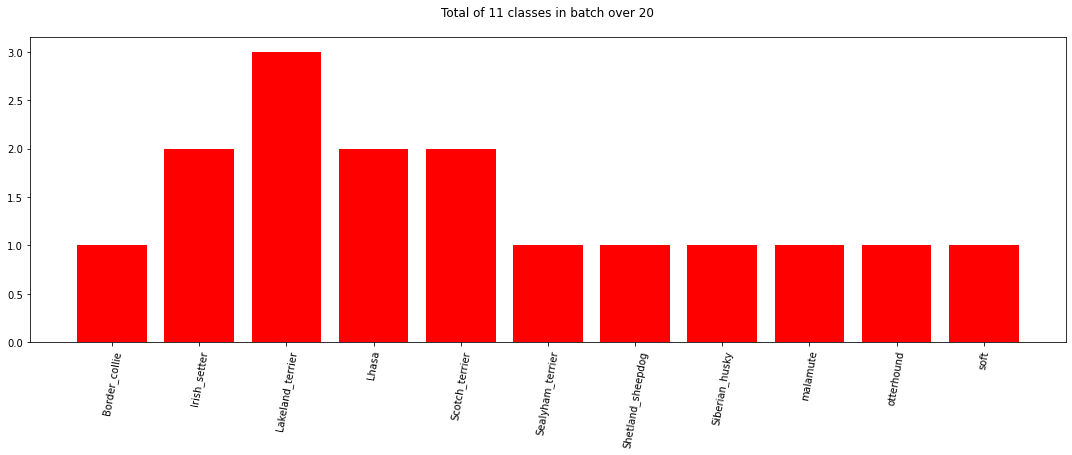

In [15]:
show_classes_in_batch(dataset.take(1))

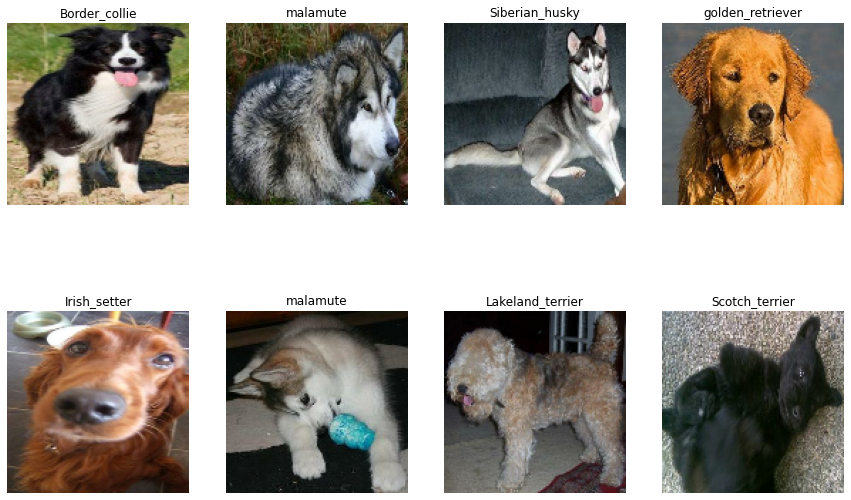

In [16]:
show_images_in_batch(dataset.take(1), astype=True)

### Train test validation split

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, 
                              val_split=0.1, 
                              test_split=0.1, 
                              shuffle_size=10000):    
    ds_size = len(ds)
    
    ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds), len(val_ds), len(test_ds)

(171, 21, 22)

In [20]:
len(dataset)

214

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Util functions

In [22]:
def plot_model_history(history):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(EPOCHS), acc, label='Training Accuracy')
    plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(range(EPOCHS), loss, label='Training Loss')
    plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array, verbose=0)
    predicted_class = class_names[np.argmax(predictions[0])]
    # Confidence for 'predict.py' script
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

def plot_model_cm(model,ds):
    # Inference on ds
    predicted_classes = []
    actual_classes = []
    for (images, labels) in ds:
        for i in range(len(images)):        
            predicted_class, _ = predict(model, images[i].numpy())
            predicted_classes.append(predicted_class)
            actual_class = class_names[labels[i]]
            actual_classes.append(actual_class)
            
    # Construction of cm
    cm = confusion_matrix(actual_classes, predicted_classes, labels=class_names)
    # Plot
    plt.figure(figsize=(15,10))
    c = sns.heatmap(cm, annot=True, fmt='g', cbar=False)
    c.set_xlabel('Predicted')
    c.set_ylabel('Truth')
    c.xaxis.set_ticklabels(class_names)
    c.yaxis.set_ticklabels(class_names)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

### Preprocessing

In [23]:
from tensorflow.keras import layers

### mapping cv2 pre-processing

In [24]:
import cv2

def prep_images(x):
    dst_image=[]
    for i in range(x.shape[0]):
        img = x.numpy()[i].astype("uint8")
        img_YUV = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
        # Equalization
        img_YUV[:,:,0] = cv2.equalizeHist(img_YUV[:,:,0])
        img_equ = cv2.cvtColor(img_YUV, cv2.COLOR_YUV2RGB)
        # Apply non-local means filter on test img
        dst_img = cv2.fastNlMeansDenoisingColored(
            src=img_equ,
            dst=None,
            h=10,
            hColor=10,
            templateWindowSize=7,
            searchWindowSize=21)
        dst_image.append(dst_img)
    out_img = tf.convert_to_tensor(np.array(dst_image), dtype=tf.float32)
    return out_img

def parse_func(x):
    out = tf.py_function(prep_images, [x], tf.float32)
    return out

In [25]:
# 
train_ds = train_ds.map(
    lambda x,y: (parse_func(x),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.map(
    lambda x,y: (parse_func(x),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### rescale data

In [26]:
# rescaling data
data_rescale = tf.keras.Sequential([
    layers.Input(shape=images_shape),
    layers.Rescaling(1./(255),input_shape=images_shape)
],name = "data_rescaling_layer")

train_ds = train_ds.map(
    lambda x, y: (data_rescale(x), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.map(
    lambda x, y: (data_rescale(x), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
# show_images_in_batch(train_ds.take(1), astype=False)

### For inference

In [28]:
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# preprocessing
test_ds = test_ds.map(
    lambda x,y: (parse_func(x),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# rescaling
test_ds = test_ds.map(
    lambda x, y: (data_rescale(x), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Data augmentation

In [29]:
# data augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)
],name = "data_augmentation_layer")

## <font color="red" id=section_3_2> 3.2 CNN. </font>


Ci-dessous le modèle CNN baseline.

In [ ]:
cnn_model = keras.models.Sequential([
    data_rescale,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size = (3,3), input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
   
    layers.Conv2D(64, (3, 3)), 
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    

    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(n_classes, activation='softmax'),
])

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['sparse_categorical_accuracy']
)

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_rescaling_layer (Seque  (None, 128, 128, 3)      0         
 ntial)                                                          
                                                                 
 data_augmentation_layer (Se  (None, 128, 128, 3)      0         
 quential)                                                       
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 126, 126, 32)      0         
                                                        

In [ ]:
EPOCHS = 30
cnn_h = cnn_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
171/171 [==============================] - 1141s 1s/step - loss: 3.1996 - sparse_categorical_accuracy: 0.0529 - val_loss: 2.9932 - val_sparse_categorical_accuracy: 0.0655
Epoch 2/30
171/171 [==============================] - 174s 1s/step - loss: 2.9388 - sparse_categorical_accuracy: 0.0668 - val_loss: 2.9903 - val_sparse_categorical_accuracy: 0.0744
Epoch 3/30
171/171 [==============================] - 174s 1s/step - loss: 2.8930 - sparse_categorical_accuracy: 0.1043 - val_loss: 2.9884 - val_sparse_categorical_accuracy: 0.0744
Epoch 4/30
171/171 [==============================] - 176s 1s/step - loss: 2.8640 - sparse_categorical_accuracy: 0.1072 - val_loss: 2.9874 - val_sparse_categorical_accuracy: 0.0744
Epoch 5/30
171/171 [==============================] - 174s 1s/step - loss: 2.8403 - sparse_categorical_accuracy: 0.1043 - val_loss: 2.9876 - val_sparse_categorical_accuracy: 0.0744
Epoch 6/30
171/171 [==============================] - 173s 1s/step - loss: 2.8324 - sparse_cat

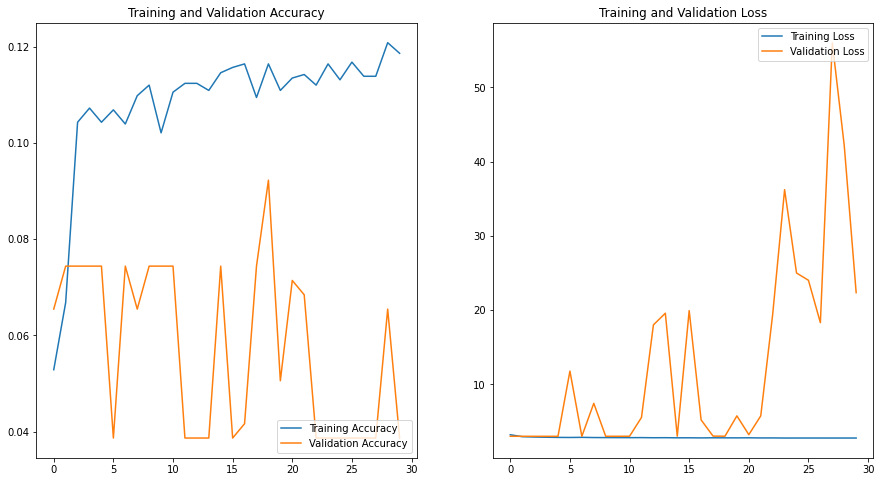

In [ ]:
plot_model_history(cnn_h)

In [ ]:
cnn_model.evaluate(test_ds)

22/22 [==============================] - 20s 916ms/step - loss: 20.4973 - sparse_categorical_accuracy: 0.0653


[20.49730110168457, 0.06534090638160706]

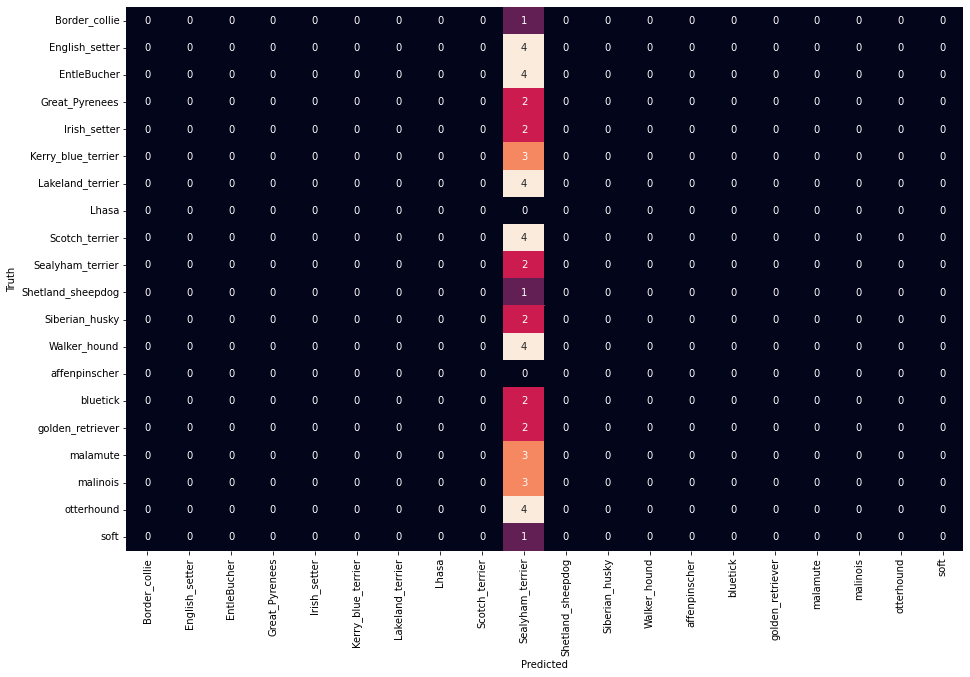

In [ ]:
plot_model_cm(cnn_model,test_ds.take(3))

La simplicité du modèle basline explique clairement la faiblaisse des performances. Entraîner un modèle Deep Learning performant *from scratch* est coûteux en temps de calcul et de ressources numériques. De manière générale, plus un réseau est profond plus les features détectées sont complexes et donc meilleurs les résultats sont. Le problème est que l'on peut être confrontés au problème de "disparition" progressive du gradient lors de l'étape de rétropropagation. Les modèles pré-entraînés que nous utiliserons dans ce notebook ont leurs propres méthodes pour palier à ce problème.

## <font color="red" id=section_3_3> 3.3 Transfer Learning avec `keras_tuner`. </font>

Nous allons maintenant utiliser les modèles pré-entraîné de la littérature pour avoir de meilleures performances. Afin de ne pas écraser l'apprentissae déjà récupéré, les couches de ces modèles seront *freezed*. On fait alors du transfer learning par fine-tuning. On utilise `keras_tuner` pour optimiser le nombre de couches complètement connectés (au plus deux couches et avec/sans une couche de régularisation Dropout) ainsi que les hyperparamètres (nombre de neurones de chaque couche dense et taux du Dropout). Enfin, on ajoute la dernière couche complètement connecté qui fera la classification. Lorsque aucune couche dense n'est présente entre les couches du modèle et le classifieur, on fait du transfer learning par feature extraction. Les trois modèles que l'on va utiliser dans ce notebook ont tous été entraîné sur la base d'image open-source ImageNet dont notre dataset fait partie :


1. `VGG16` : Son architecture classique est formée par une répétition de blocs de deux ou trois couches de convolution pour atteindre un total de 16 ou 19 couches selon les variantes. Elle utilisait uniquement, et en grand nombre, des filtres de dimension 3×3. Ici, on utilise la variante à 16 couches.


2. `Xception` : est une amélioration de l'architecture `Inception`. La particularité du bloc Inception est qu'il effectue les opérations de convolutions avec des filtres de tailles différentes en parallèle. 


3. `ResNet50` : Cette architecture est basé sur le principe de l'apprentissage résiduel. Dans ce modèle, le bloc qui se répète est appelé le "bloc résiduel": on ajoute la feature map en input à la sortie d'un bloc de deux couches de convolution. La variante utilisée ici est constituée de 50 couches de convolutions, on peut aller jusqu'à 152 couches de profondeurs.

In [ ]:
# architecture
def call_existing_code(tl_model, units, flatt_pool, booleans, dropouts, lr):

    inputs = layers.Input(shape=images_shape)
    # inputs = data_rescale(inputs)
    inputs = data_augmentation(inputs)

    # Freeze """TransfertLearning_Model""" trained weights
    for layer in tl_model.layers:
        layer.trainable = False    
    # get tl_model output
    x = tl_model(inputs)

    # Flatten or GlobalAvgPooling layer
    if flatt_pool == 'Flatten':
        x = layers.Flatten(name='Flattened_lay')(x)
    else:
        x = layers.GlobalAveragePooling2D(name='GlobalAvgPooling_lay')(x)
    # Boolean Dense Layer
    if booleans[0]:
        x = layers.Dense(units[0], activation='relu', name="int_0_dense_lay")(x)    
    # Boolean Dense Layer
    if booleans[1]:
        x = layers.Dense(units[1], activation='relu', name="int_1_dense_lay")(x)
    # Boolean Dropout Layer
    if booleans[2]:
        x = layers.Dropout(rate=dropouts[0], name=f"dr_0_lay")(x)
    # Last Dense Softmax layer    
    x = layers.Dense(n_classes, activation='softmax', name='softmax_lay')(x)

    model = keras.models.Model(inputs=inputs, outputs=x)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['sparse_categorical_accuracy'] #[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')] #  
    )

    return model

In [ ]:
# build
def kt_for_model(tl_model, kt_optimizer):    
    
    def build_model(hp):
        # HyperParameters    
        flatt_pool   = hp.Choice('Flatten_or_GlobalAvgPool', ['GlobalAvgPool', 'Flatten'])

        boolean_0    = hp.Boolean("boolean_units_0")
        units_0      = hp.Int("units_0", min_value=64, max_value=512, step=32)

        boolean_1    = hp.Boolean("boolean_units_1")
        units_1      = hp.Int("units_1", min_value=64, max_value=512, step=32)

        boolean_2    = hp.Boolean("boolean_dr_0")
        dr_0         = hp.Float("dr_0", min_value=0.1, max_value=0.5, sampling="linear")

        lr           = 1e-3 # hp.Float("lr", min_value=1e-6, max_value=1e-3, sampling="log")
        
        # call existing model-building code with the hyperparameter values.
        model = call_existing_code(tl_model=tl_model,
                                   units=[units_0,
                                          units_1],
                                  flatt_pool=flatt_pool,
                                  booleans=[boolean_0, 
                                            boolean_1, 
                                            boolean_2], 
                                  dropouts=[dr_0], 
                                  lr=lr)
        return model

    # tuner 
    tuner_search=kt_optimizer(
        build_model,
        objective='val_sparse_categorical_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory='output',
        overwrite=True
    )
    
    return tuner_search

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=1,
    restore_best_weights=True
)

### VGG16

In [34]:
# Load
vgg16 = keras.applications.VGG16(
    weights='imagenet',  
    input_shape=images_shape, 
    include_top=False
)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# Build
vgg16_keras_tuner = kt_for_model(
    vgg16, 
    keras_tuner.RandomSearch
)
vgg16_keras_tuner.search_space_summary()

Search space summary
Default search space size: 7
Flatten_or_GlobalAvgPool (Choice)
{'default': 'GlobalAvgPool', 'conditions': [], 'values': ['GlobalAvgPool', 'Flatten'], 'ordered': False}
boolean_units_0 (Boolean)
{'default': False, 'conditions': []}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': None}
boolean_units_1 (Boolean)
{'default': False, 'conditions': []}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': None}
boolean_dr_0 (Boolean)
{'default': False, 'conditions': []}
dr_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}


In [ ]:
# Search
vgg16_keras_tuner.search(
    train_ds,
    epochs=2,
    validation_data=val_ds, 
    callbacks=[stop_early]
)

Trial 10 Complete [00h 07m 14s]
val_sparse_categorical_accuracy: 0.7529761791229248

Best val_sparse_categorical_accuracy So Far: 0.8184523582458496
Total elapsed time: 01h 15m 04s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
vgg16_best_hps = vgg16_keras_tuner.get_best_hyperparameters(num_trials=1)[0]
vgg16_best_hps.values

{'Flatten_or_GlobalAvgPool': 'Flatten',
 'boolean_units_0': False,
 'units_0': 128,
 'boolean_units_1': False,
 'units_1': 352,
 'boolean_dr_0': False,
 'dr_0': 0.2019011674867698}

In [ ]:
# Build the model with the optimal hyperparameters 
vgg16_best = vgg16_keras_tuner.hypermodel.build(vgg16_best_hps)
vgg16_best.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 Flattened_lay (Flatten)     (None, 8192)              0         
                                                                 
 softmax_lay (Dense)         (None, 20)                163860    
                                                                 
Total params: 14,878,548
Trainable params: 163,860
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Retrain model on the data for EPOCHS epochs
EPOCHS = 10
vgg16_hist = vgg16_best.fit(
    train_ds, 
    epochs=EPOCHS, 
    validation_data=val_ds
)

Epoch 1/10
171/171 [==============================] - 217s 1s/step - loss: 2.0736 - sparse_categorical_accuracy: 0.3838 - val_loss: 1.0732 - val_sparse_categorical_accuracy: 0.6786
Epoch 2/10
171/171 [==============================] - 216s 1s/step - loss: 0.8658 - sparse_categorical_accuracy: 0.7470 - val_loss: 0.6294 - val_sparse_categorical_accuracy: 0.8482
Epoch 3/10
171/171 [==============================] - 216s 1s/step - loss: 0.4935 - sparse_categorical_accuracy: 0.8832 - val_loss: 0.5546 - val_sparse_categorical_accuracy: 0.8839
Epoch 4/10
171/171 [==============================] - 216s 1s/step - loss: 0.2986 - sparse_categorical_accuracy: 0.9545 - val_loss: 0.4158 - val_sparse_categorical_accuracy: 0.9196
Epoch 5/10
171/171 [==============================] - 216s 1s/step - loss: 0.1887 - sparse_categorical_accuracy: 0.9813 - val_loss: 0.3588 - val_sparse_categorical_accuracy: 0.9256
Epoch 6/10
171/171 [==============================] - 216s 1s/step - loss: 0.1183 - sparse_cate

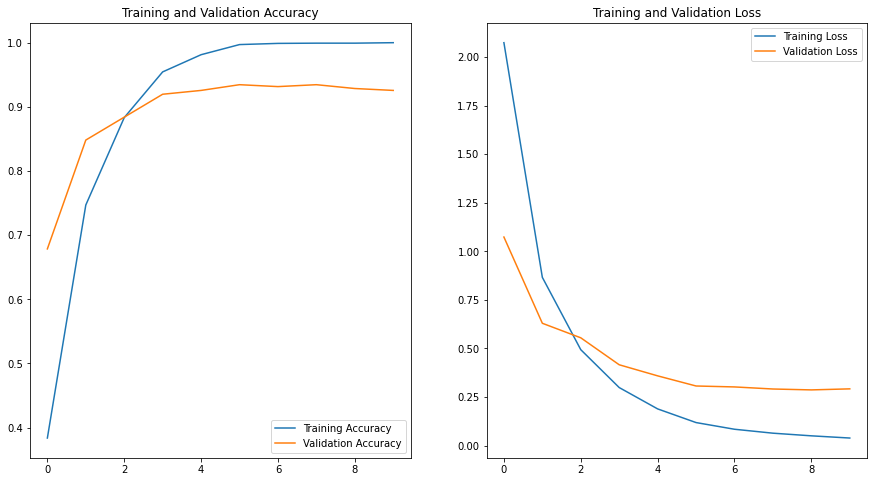

In [ ]:
# Model history
plot_model_history(vgg16_hist)

In [ ]:
# Evaluate on test set
vgg16_best.evaluate(test_ds)

22/22 [==============================] - 26s 1s/step - loss: 0.2561 - sparse_categorical_accuracy: 0.9261


[0.2561113238334656, 0.9261363744735718]

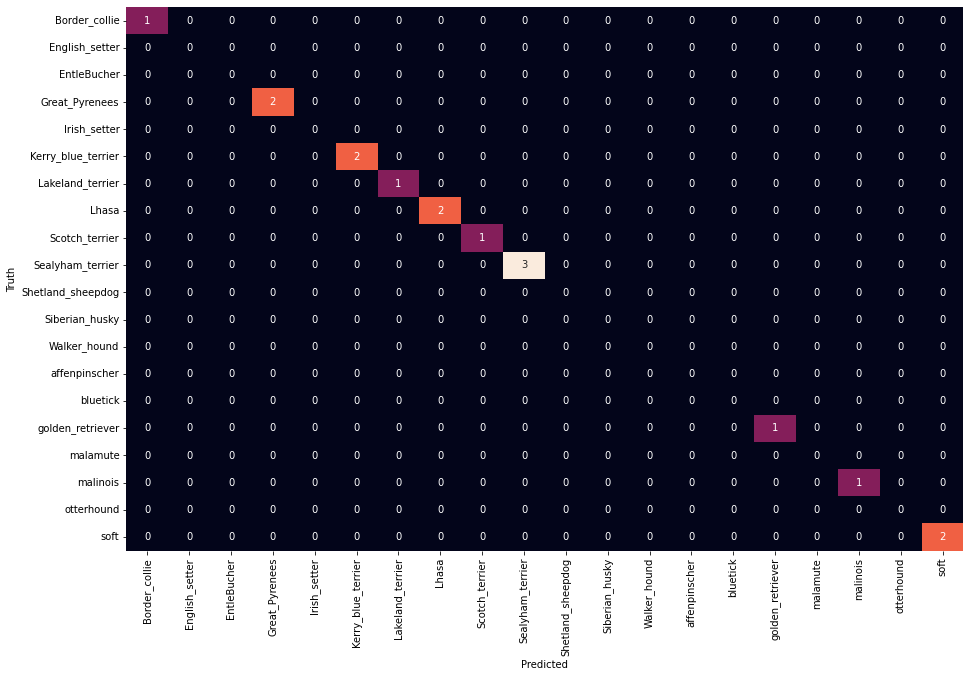

In [ ]:
# Confusion matrix
plot_model_cm(vgg16_best,test_ds.take(1))

### Xcep

In [ ]:
# Load
Xcep = keras.applications.Xception(
    weights='imagenet',
    input_shape=images_shape, 
    include_top=False 
)  

In [ ]:
# Build
xcep_keras_tuner = kt_for_model(
    Xcep, 
    keras_tuner.RandomSearch
)
xcep_keras_tuner.search_space_summary()

Search space summary
Default search space size: 7
Flatten_or_GlobalAvgPool (Choice)
{'default': 'GlobalAvgPool', 'conditions': [], 'values': ['GlobalAvgPool', 'Flatten'], 'ordered': False}
boolean_units_0 (Boolean)
{'default': False, 'conditions': []}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': None}
boolean_units_1 (Boolean)
{'default': False, 'conditions': []}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': None}
boolean_dr_0 (Boolean)
{'default': False, 'conditions': []}
dr_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}


In [ ]:
# Search
xcep_keras_tuner.search(
    train_ds,
    epochs=2,
    validation_data=val_ds, 
    callbacks=[stop_early]
)

Trial 10 Complete [00h 05m 51s]
val_sparse_categorical_accuracy: 0.7976190447807312

Best val_sparse_categorical_accuracy So Far: 0.8214285969734192
Total elapsed time: 00h 59m 11s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
xcep_best_hps = xcep_keras_tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# Build the model with the optimal hyperparameters 
xcep_best = xcep_keras_tuner.hypermodel.build(xcep_best_hps)
xcep_best.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 GlobalAvgPooling_lay (Globa  (None, 2048)             0         
 lAveragePooling2D)                                              
                                                                 
 int_1_dense_lay (Dense)     (None, 416)               852384    
                                                                 
 softmax_lay (Dense)         (None, 20)                8340      
                                                                 
Total params: 21,722,204
Trainable params: 860,724
Non-trainable params: 20,861,480
_________________________________________

In [ ]:
# Retrain model on the data for EPOCHS epochs
EPOCHS = 10
xcep_hist = xcep_best.fit(
    train_ds, 
    epochs=EPOCHS, 
    validation_data=val_ds
)

Epoch 1/10
171/171 [==============================] - 177s 1s/step - loss: 1.3868 - sparse_categorical_accuracy: 0.5769 - val_loss: 0.7415 - val_sparse_categorical_accuracy: 0.7619
Epoch 2/10
171/171 [==============================] - 174s 1s/step - loss: 0.7429 - sparse_categorical_accuracy: 0.7606 - val_loss: 0.5479 - val_sparse_categorical_accuracy: 0.8155
Epoch 3/10
171/171 [==============================] - 174s 1s/step - loss: 0.4834 - sparse_categorical_accuracy: 0.8454 - val_loss: 0.4993 - val_sparse_categorical_accuracy: 0.8482
Epoch 4/10
171/171 [==============================] - 174s 1s/step - loss: 0.3634 - sparse_categorical_accuracy: 0.8762 - val_loss: 0.4849 - val_sparse_categorical_accuracy: 0.8720
Epoch 5/10
171/171 [==============================] - 174s 1s/step - loss: 0.1924 - sparse_categorical_accuracy: 0.9449 - val_loss: 0.3531 - val_sparse_categorical_accuracy: 0.9077
Epoch 6/10
171/171 [==============================] - 174s 1s/step - loss: 0.1172 - sparse_cate

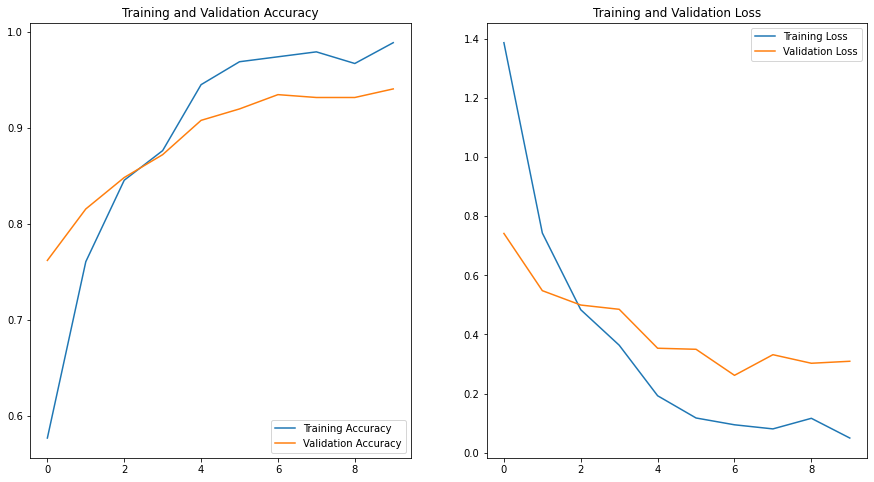

In [ ]:
# Model history
plot_model_history(xcep_hist)

In [ ]:
# Evaluate on test set
xcep_best.evaluate(test_ds)

22/22 [==============================] - 20s 910ms/step - loss: 0.3398 - sparse_categorical_accuracy: 0.9347


[0.3397843539714813, 0.9346590638160706]

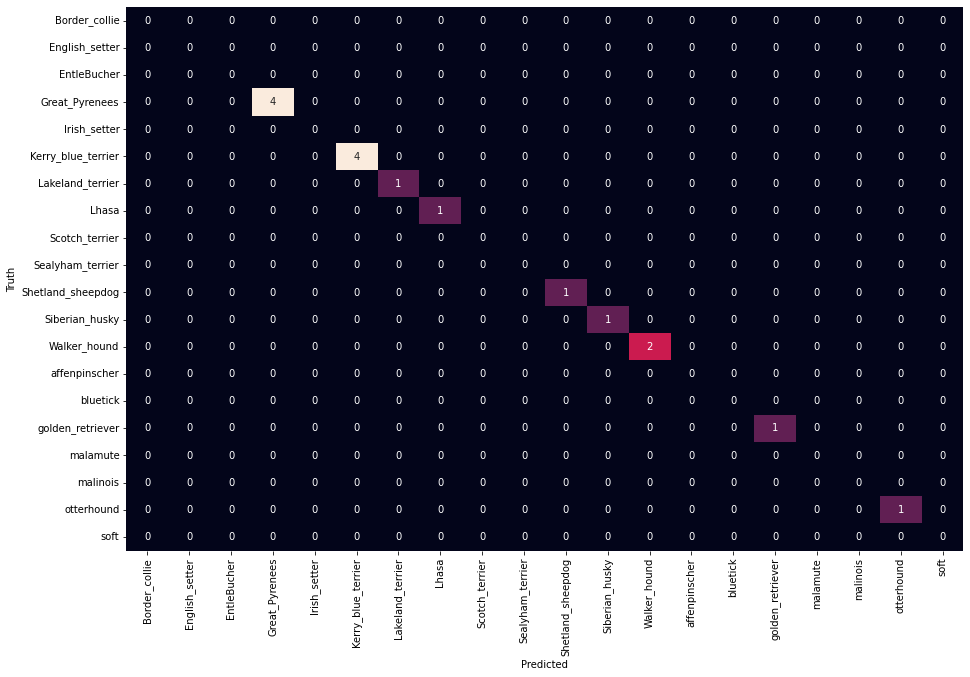

In [ ]:
# Confusion matrix
plot_model_cm(xcep_best,test_ds.take(1))

### ResNet50

In [ ]:
# Load
rn50 = keras.applications.ResNet50(
    weights='imagenet', 
    input_shape=images_shape, 
    include_top=False
)

In [ ]:
# Build
rn50_keras_tuner = kt_for_model(
    rn50, 
    keras_tuner.RandomSearch
)
rn50_keras_tuner.search_space_summary()

Search space summary
Default search space size: 7
Flatten_or_GlobalAvgPool (Choice)
{'default': 'GlobalAvgPool', 'conditions': [], 'values': ['GlobalAvgPool', 'Flatten'], 'ordered': False}
boolean_units_0 (Boolean)
{'default': False, 'conditions': []}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': None}
boolean_units_1 (Boolean)
{'default': False, 'conditions': []}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': None}
boolean_dr_0 (Boolean)
{'default': False, 'conditions': []}
dr_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}


In [ ]:
# Search
rn50_keras_tuner.search(
    train_ds,
    epochs=3,
    validation_data=val_ds, 
    callbacks=[stop_early]
)

Trial 10 Complete [00h 09m 16s]
val_sparse_categorical_accuracy: 0.1696428507566452

Best val_sparse_categorical_accuracy So Far: 0.3571428656578064
Total elapsed time: 01h 30m 04s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
rn50_best_hps = rn50_keras_tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
rn50_best_hps.values

{'Flatten_or_GlobalAvgPool': 'Flatten',
 'boolean_units_0': False,
 'units_0': 352,
 'boolean_units_1': False,
 'units_1': 320,
 'boolean_dr_0': False,
 'dr_0': 0.2100964663848736}

In [ ]:
# Build the model with the optimal hyperparameters 
rn50_best = rn50_keras_tuner.hypermodel.build(rn50_best_hps)
rn50_best.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 Flattened_lay (Flatten)     (None, 32768)             0         
                                                                 
 softmax_lay (Dense)         (None, 20)                655380    
                                                                 
Total params: 24,243,092
Trainable params: 655,380
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# Retrain model on the data for EPOCHS epochs
EPOCHS = 50
rn50_hist = rn50_best.fit(
    train_ds, 
    epochs=EPOCHS, 
    validation_data=val_ds
)

Epoch 1/50
171/171 [==============================] - 189s 1s/step - loss: 3.0111 - sparse_categorical_accuracy: 0.1124 - val_loss: 2.7181 - val_sparse_categorical_accuracy: 0.1756
Epoch 2/50
171/171 [==============================] - 184s 1s/step - loss: 2.6755 - sparse_categorical_accuracy: 0.2038 - val_loss: 2.3381 - val_sparse_categorical_accuracy: 0.2827
Epoch 3/50
171/171 [==============================] - 178s 1s/step - loss: 2.4197 - sparse_categorical_accuracy: 0.2622 - val_loss: 2.2769 - val_sparse_categorical_accuracy: 0.3720
Epoch 4/50
171/171 [==============================] - 178s 1s/step - loss: 2.3208 - sparse_categorical_accuracy: 0.2912 - val_loss: 2.1010 - val_sparse_categorical_accuracy: 0.3810
Epoch 5/50
171/171 [==============================] - 178s 1s/step - loss: 2.1685 - sparse_categorical_accuracy: 0.3401 - val_loss: 2.0317 - val_sparse_categorical_accuracy: 0.4137
Epoch 6/50
171/171 [==============================] - 178s 1s/step - loss: 2.0565 - sparse_cate

171/171 [==============================] - 178s 1s/step - loss: 0.8498 - sparse_categorical_accuracy: 0.7741 - val_loss: 1.1638 - val_sparse_categorical_accuracy: 0.7054
Epoch 47/50
171/171 [==============================] - 178s 1s/step - loss: 0.8517 - sparse_categorical_accuracy: 0.7694 - val_loss: 1.1507 - val_sparse_categorical_accuracy: 0.6964
Epoch 48/50
171/171 [==============================] - 178s 1s/step - loss: 0.8234 - sparse_categorical_accuracy: 0.7811 - val_loss: 1.1276 - val_sparse_categorical_accuracy: 0.7113
Epoch 49/50
171/171 [==============================] - 178s 1s/step - loss: 0.8435 - sparse_categorical_accuracy: 0.7598 - val_loss: 1.1282 - val_sparse_categorical_accuracy: 0.7292
Epoch 50/50
171/171 [==============================] - 178s 1s/step - loss: 0.7930 - sparse_categorical_accuracy: 0.7910 - val_loss: 1.0629 - val_sparse_categorical_accuracy: 0.7411


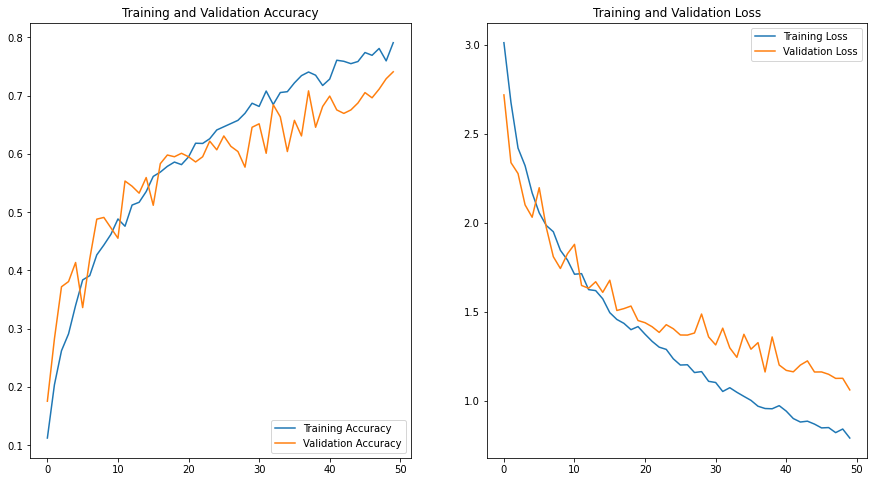

In [ ]:
# Model history
plot_model_history(rn50_hist)

In [ ]:
# Evaluate on test set
rn50_best.evaluate(test_ds)

22/22 [==============================] - 21s 949ms/step - loss: 1.1775 - sparse_categorical_accuracy: 0.7188


[1.1774784326553345, 0.71875]

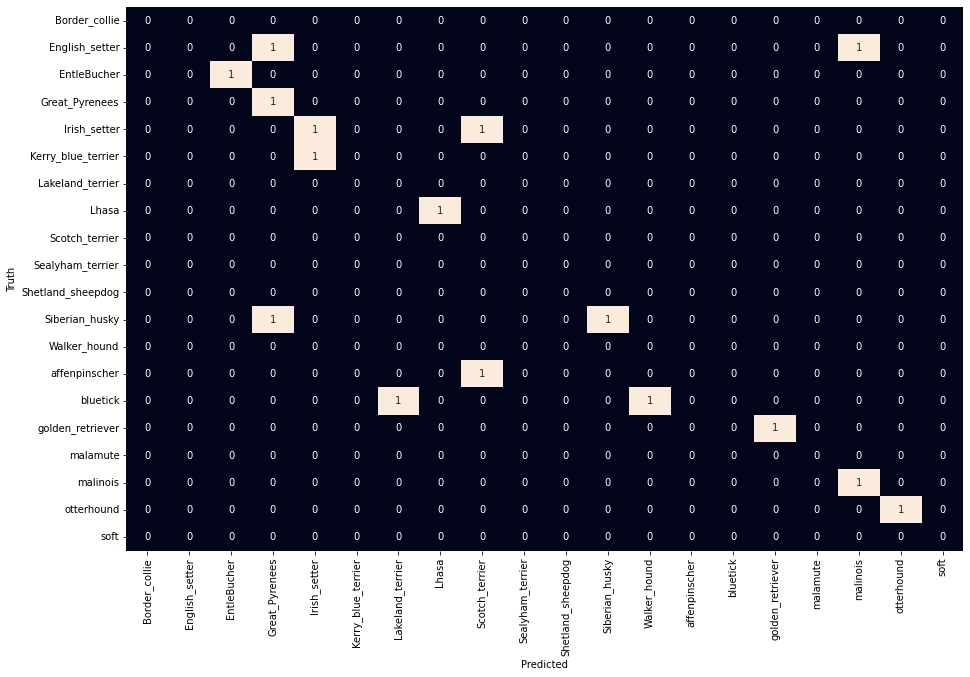

In [ ]:
# Confusion matrix
plot_model_cm(rn50_best,test_ds.take(1))

## En conclusion

Pour 10 epochs, on trouve que `VGG16` et `Xception` ont de bien meilleures performances que le modèle `ResNet50` sur cet échantillon du dataset original. Ce dernier nécessite certainement un nombre d'epochs de l'ordre de 100 pour atteindre le même ordre de performance. Bien que les deux premiers soient comparables, on utilisera le modèle `Xception` pour le déploiement sur l'image docker ci-jointe.[docker image] 